### Importação de Bibliotecas

In [117]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
import time
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GroupKFold, KFold
from sklearn.tree import export_graphviz
import graphviz
from pandas.plotting import scatter_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print(sns.__version__)

0.11.2


### Importação de Dados

In [118]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
df = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
df.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


### Situação de "Azar" onde as classes estão Ordenadas

In [119]:
df_bad = df.sort_values("vendido", ascending=True)
x_bad = df_bad[["preco", "idade_do_modelo", "km_por_ano"]]
y_bad = df_bad["vendido"]
df_bad.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


### Treinamento com Dummy para se obter uma métrica Base

In [120]:
SEED = 301
np.random.seed(SEED)

dummy_model = DummyClassifier()
results = cross_validate(dummy_model, x_bad, y_bad, cv=10, return_train_score=False)

media = results["test_score"].mean()
desvio_padrao = results["test_score"].std()
print(
    "Accuracy com Dummy Estratificado (CV10): %.2f%% a %.2f%%"
    % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100)
)

Accuracy com Dummy Estratificado (CV10): 58.00% a 58.00%


### Treinamento com Árvore de Decisão

In [121]:
SEED = 301
np.random.seed(SEED)

dtc_model = DecisionTreeClassifier(max_depth=2)
results = cross_validate(dtc_model, x_bad, y_bad, cv=10, return_train_score=False)

media = results["test_score"].mean()
desvio_padrao = results["test_score"].std()
print(
    "Accuracy com Decision Tree Classifier (CV10): %.2f%% a %.2f%%"
    % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100)
)

Accuracy com Decision Tree Classifier (CV10): 73.83% a 77.73%


### Geração de Dados de Modelo para Simulação de Agrupamento do Estimador

In [122]:
np.random.seed(SEED)

df["modelo"] = df.idade_do_modelo + np.random.randint(-2, 3, size=10000)
df.modelo = df.modelo + abs(df.modelo.min()) + 1

df.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


### Função para exibir Métricas

In [123]:
def print_results(results):
    media = results["test_score"].mean() * 100
    desvio = results["test_score"].std() * 100
    print("Acurácia Média: %.2f%%" % media)
    print(
        "Intervalo de Acurácias: %.2f%% a %.2f%%"
        % (media - 2 * desvio, media + 2 * desvio)
    )

### GroupKFold em Pipeline com StandardScaler e SVC

O GroupKFold possui a função de dividir nosso conjunto de treino e teste em k-dobras (k-fold) de forma que as amostras com mesmo grupo não sejam representadas nos conjuntos de teste e teste simultaneamente. Fazendo isso nós temos uma melhor aproximação de como o nosso modelo funcionará no mundo real, pois ele está sempre sendo treinado com dados de alguns grupos, e quando vamos testar colocamos um grupo que o nosso modelo nunca viu, e essas características podem ser algo totalmente diferentes das demais, pois amostras de grupos diferentes tendem a ter características diferentes também. Então o GroupKFold nos dá a resposta se nosso modelo é generalista ou não.

<img src="https://i.stack.imgur.com/a0qtJ.png">

O StandardScaler padroniza as features removendo a média e escala a variância a uma unidade. Isso significa que para cada feature, a média seria 0, e o Desvio Padrão seria 1. Desta forma, as features são padronizadas, tornando-as mais manejáveis para nossos modelos.

<img src="https://i.stack.imgur.com/PZgJ2.png">

O SVM (Support Vector Machine) (SVC, NuSVC, etc) é um classificador discriminativo formalmente definido por um hiperplano de separação. Em outras palavras, se temos dados de treinamento rotulados (aprendizado supervisionado), o algoritmo gera um hiperplano ideal que categoriza novos dados inéditos. Classificador.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png">

In [124]:
SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
svc_model = SVC()

pipeline = Pipeline([("Scaler", scaler), ("Model", svc_model)])

cv = GroupKFold(n_splits=10)

tic = time.time()
results = cross_validate(
    pipeline, x_bad, y_bad, cv=cv, groups=df.modelo, return_train_score=False
)
tac = time.time()

print(f"Tempo de Treinamento: {'{:.2f}'.format(tac - tic)} segundos")
print_results(results)

Tempo de Treinamento: 16.36 segundos
Acurácia Média: 76.68%
Intervalo de Acurácias: 74.28% a 79.08%


### GroupKFold com Decision Tree Classifier e Análise da Árvore

In [125]:
SEED = 301
np.random.seed(SEED)


cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=2)

tic = time.time()
results = cross_validate(
    modelo, x_bad, y_bad, cv=cv, groups=df.modelo, return_train_score=False
)
tac = time.time()

print(f"Tempo de Treinamento: {'{:.2f}'.format(tac - tic)} segundos")
print_results(results)

Tempo de Treinamento: 0.08 segundos
Acurácia Média: 75.78%
Intervalo de Acurácias: 73.67% a 77.90%


### Análise da Árvore

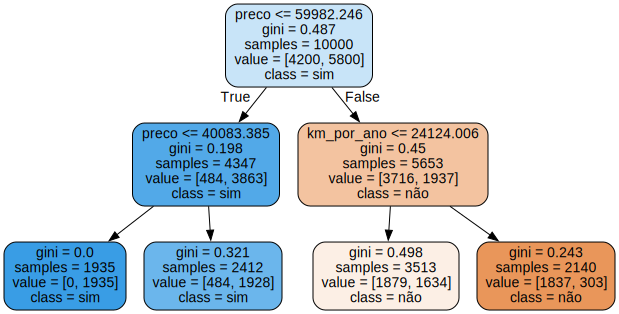

In [126]:
modelo.fit(x_bad, y_bad)

features = x_bad.columns

dot_data = export_graphviz(
    modelo,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=["não", "sim"],
    feature_names=features,
)

graph = graphviz.Source(dot_data)
graph

### GroupKFold com Decision Tree Classifier com Maior Profundidade e Análise da Árvore

In [127]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=3)

tic = time.time()
results = cross_validate(
    modelo, x_bad, y_bad, cv=cv, groups=df.modelo, return_train_score=False
)
tac = time.time()

print(f"Tempo de Treinamento: {'{:.2f}'.format(tac - tic)} segundos")
print_results(results)

Tempo de Treinamento: 0.09 segundos
Acurácia Média: 78.67%
Intervalo de Acurácias: 76.40% a 80.94%


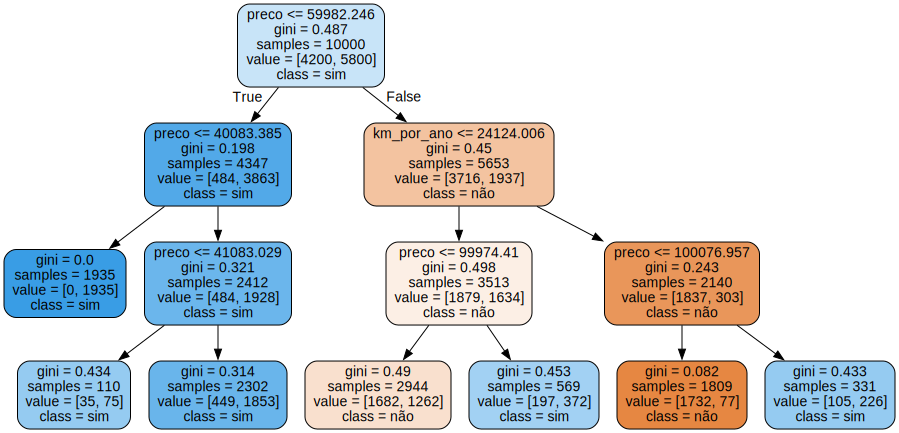

In [128]:
modelo.fit(x_bad, y_bad)

features = x_bad.columns

dot_data = export_graphviz(
    modelo,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=["não", "sim"],
    feature_names=features,
)

graph = graphviz.Source(dot_data)
graph

In [129]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=10)

tic = time.time()
results = cross_validate(
    modelo, x_bad, y_bad, cv=cv, groups=df.modelo, return_train_score=False
)
tac = time.time()

print(f"Tempo de Treinamento: {'{:.2f}'.format(tac - tic)} segundos")
print_results(results)

Tempo de Treinamento: 0.19 segundos
Acurácia Média: 77.19%
Intervalo de Acurácias: 75.26% a 79.13%


### Explorando Hiperparâmetros em uma Dimensão

In [130]:
def run_dtc_model(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(
        modelo, x_bad, y_bad, cv=cv, groups=df.modelo, return_train_score=True
    )

    train_score = results["train_score"].mean() * 100
    test_score = results["test_score"].mean() * 100

    print(
        "Max Depth = %d\tAcurácia de Treino = %.2f\tAcurácia de Teste = %.2f"
        % (max_depth, train_score, test_score)
    )
    return [max_depth, train_score, test_score]


results = [run_dtc_model(i) for i in range(1, 33)]
results = pd.DataFrame(results, columns=["max_depth", "train", "test"])
results

Max Depth = 1	Acurácia de Treino = 75.79	Acurácia de Teste = 75.78
Max Depth = 2	Acurácia de Treino = 75.79	Acurácia de Teste = 75.78
Max Depth = 3	Acurácia de Treino = 78.75	Acurácia de Teste = 78.67
Max Depth = 4	Acurácia de Treino = 78.79	Acurácia de Teste = 78.63
Max Depth = 5	Acurácia de Treino = 78.94	Acurácia de Teste = 78.56
Max Depth = 6	Acurácia de Treino = 79.17	Acurácia de Teste = 78.12
Max Depth = 7	Acurácia de Treino = 79.50	Acurácia de Teste = 77.96
Max Depth = 8	Acurácia de Treino = 79.89	Acurácia de Teste = 77.86
Max Depth = 9	Acurácia de Treino = 80.46	Acurácia de Teste = 77.38
Max Depth = 10	Acurácia de Treino = 81.16	Acurácia de Teste = 77.19
Max Depth = 11	Acurácia de Treino = 82.03	Acurácia de Teste = 76.97
Max Depth = 12	Acurácia de Treino = 82.89	Acurácia de Teste = 76.49
Max Depth = 13	Acurácia de Treino = 83.95	Acurácia de Teste = 75.81
Max Depth = 14	Acurácia de Treino = 85.03	Acurácia de Teste = 75.66
Max Depth = 15	Acurácia de Treino = 86.14	Acurácia de Tes

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185
7,8,79.887810,77.857951
8,9,80.459009,77.376956
9,10,81.158994,77.194204


<AxesSubplot:xlabel='max_depth', ylabel='train'>

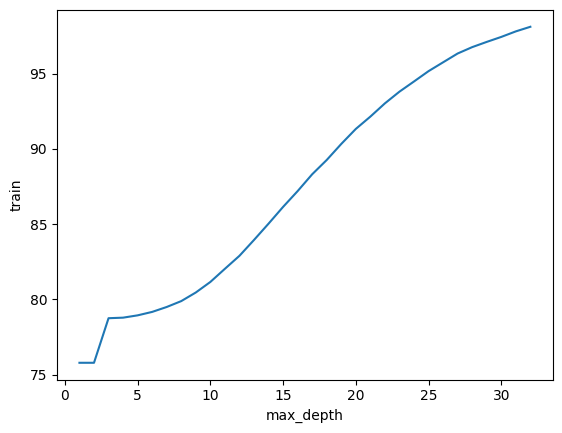

In [131]:
sns.lineplot(x="max_depth", y="train", data=results)

### Verificação de Overfitting

Modelo ficou "perfeito" para o treino mas ruim para o teste.

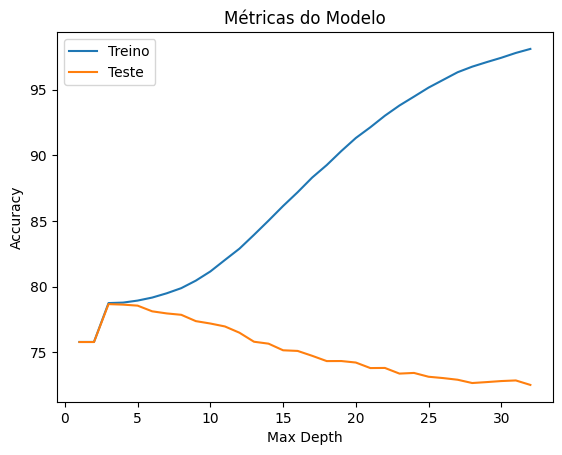

In [132]:
import matplotlib.pyplot as plt

sns.lineplot(x="max_depth", y="train", data=results)
sns.lineplot(x="max_depth", y="test", data=results)
plt.legend(["Treino", "Teste"])
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Métricas do Modelo")
plt.show()

In [133]:
results.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


### Explorando Hiperparâmetros em 2 Dimensões

In [134]:
def run_dtc_model(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_leaf=min_samples_leaf
    )
    results = cross_validate(
        modelo, x_bad, y_bad, cv=cv, groups=df.modelo, return_train_score=True
    )

    train_score = results["train_score"].mean() * 100
    test_score = results["test_score"].mean() * 100

    print(
        "Max Depth = %d\tMin Samples Leaf = %d\tAcurácia de Treino = %.2f%%\tAcurácia de Teste = %.2f%%"
        % (max_depth, min_samples_leaf, train_score, test_score)
    )
    return [max_depth, min_samples_leaf, train_score, test_score]


results = []
for max_depth in range(1, 33):
    for min_samples_leaf in [32, 64, 128, 256]:
        results.append(run_dtc_model(max_depth, min_samples_leaf))

results = pd.DataFrame(
    results, columns=["max_depth", "min_samples_leaf", "train", "test"]
)
results.head()

Max Depth = 1	Min Samples Leaf = 32	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 1	Min Samples Leaf = 64	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 1	Min Samples Leaf = 128	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 1	Min Samples Leaf = 256	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 2	Min Samples Leaf = 32	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 2	Min Samples Leaf = 64	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 2	Min Samples Leaf = 128	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 2	Min Samples Leaf = 256	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 3	Min Samples Leaf = 32	Acurácia de Treino = 78.75%	Acurácia de Teste = 78.67%
Max Depth = 3	Min Samples Leaf = 64	Acurácia de Treino = 78.75%	Acurácia de Teste = 78.67%
Max Depth = 3	Min Samples Leaf = 128	Acurácia de Treino = 78.75%	Acurácia de Teste = 7

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [135]:
results.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [142]:
corr = results.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.536705,-0.027675
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.409676,0.349011
train,5.367048e-01,-4.096762e-01,1.000000,0.116466
test,-2.767507e-02,3.490111e-01,0.116466,1.000000


<AxesSubplot:>

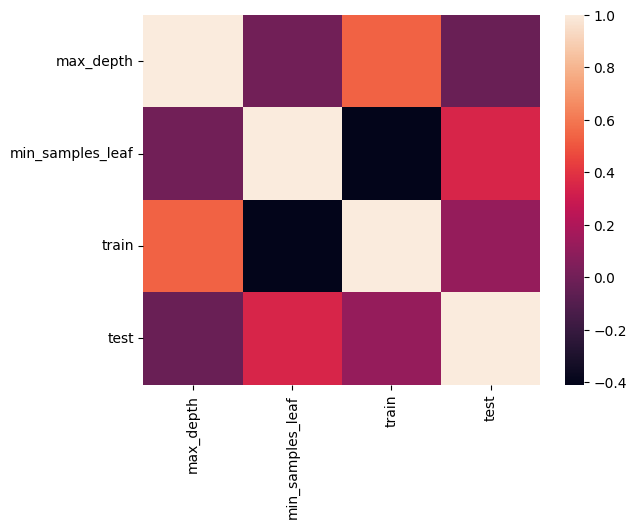

In [143]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>]], dtype=object)

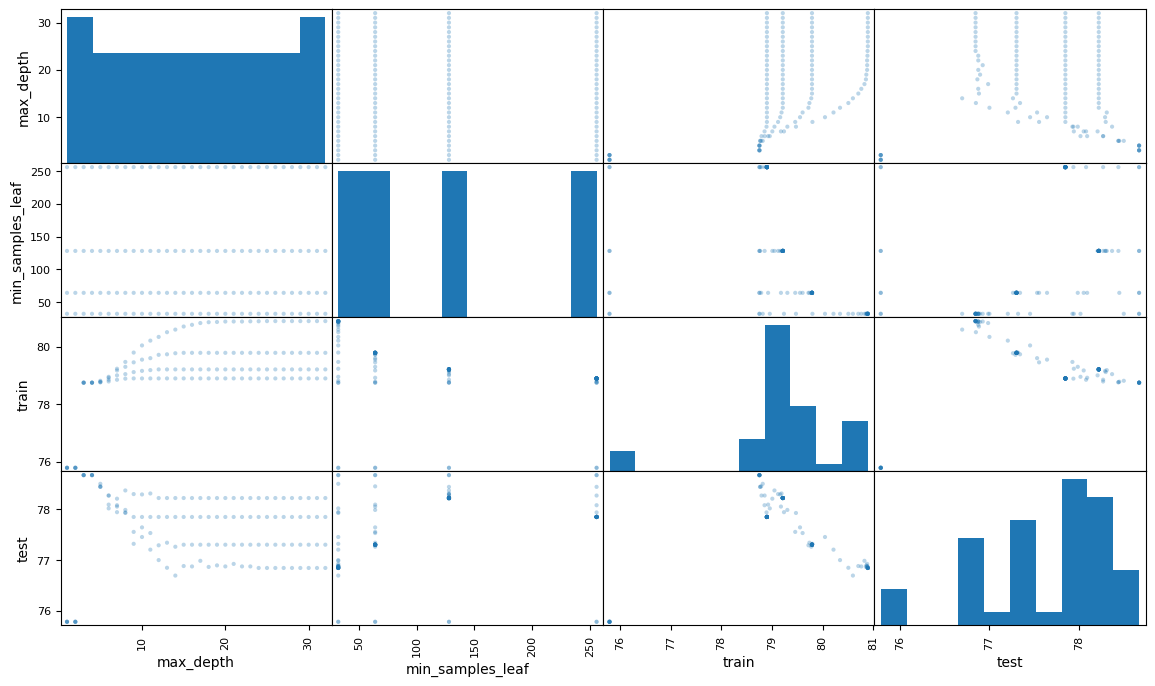

In [144]:
scatter_matrix(results, figsize=(14, 8), alpha=0.3)

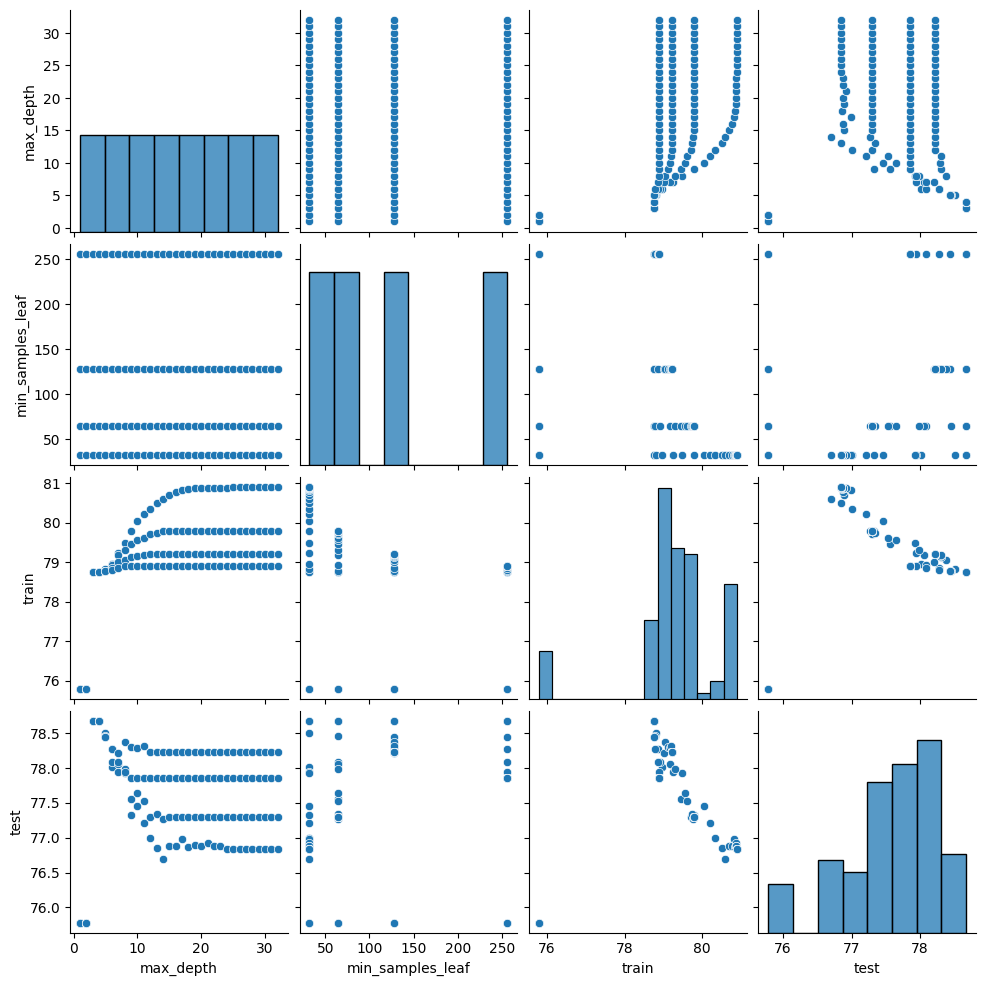

In [145]:
sns.pairplot(results)

C:\Users\jujun\AppData\Local\Temp\ipykernel_21760\3874067594.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

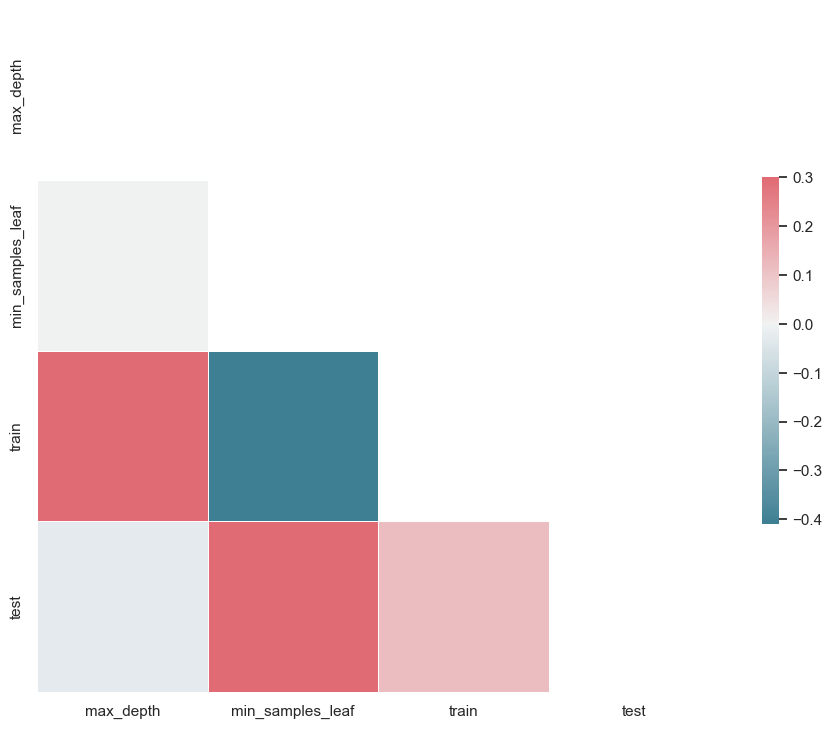

In [146]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

In [147]:
results = []
for max_depth in range(1, 33):
    for min_samples_leaf in [128, 192, 256, 512]:
        results.append(run_dtc_model(max_depth, min_samples_leaf))

results = pd.DataFrame(
    results, columns=["max_depth", "min_samples_leaf", "train", "test"]
)
results.head()

corr = results.corr()

Max Depth = 1	Min Samples Leaf = 128	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 1	Min Samples Leaf = 192	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 1	Min Samples Leaf = 256	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 1	Min Samples Leaf = 512	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 2	Min Samples Leaf = 128	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 2	Min Samples Leaf = 192	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 2	Min Samples Leaf = 256	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 2	Min Samples Leaf = 512	Acurácia de Treino = 75.79%	Acurácia de Teste = 75.78%
Max Depth = 3	Min Samples Leaf = 128	Acurácia de Treino = 78.75%	Acurácia de Teste = 78.67%
Max Depth = 3	Min Samples Leaf = 192	Acurácia de Treino = 78.75%	Acurácia de Teste = 78.67%
Max Depth = 3	Min Samples Leaf = 256	Acurácia de Treino = 78.75%	Acurácia de Tes

C:\Users\jujun\AppData\Local\Temp\ipykernel_21760\3874067594.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

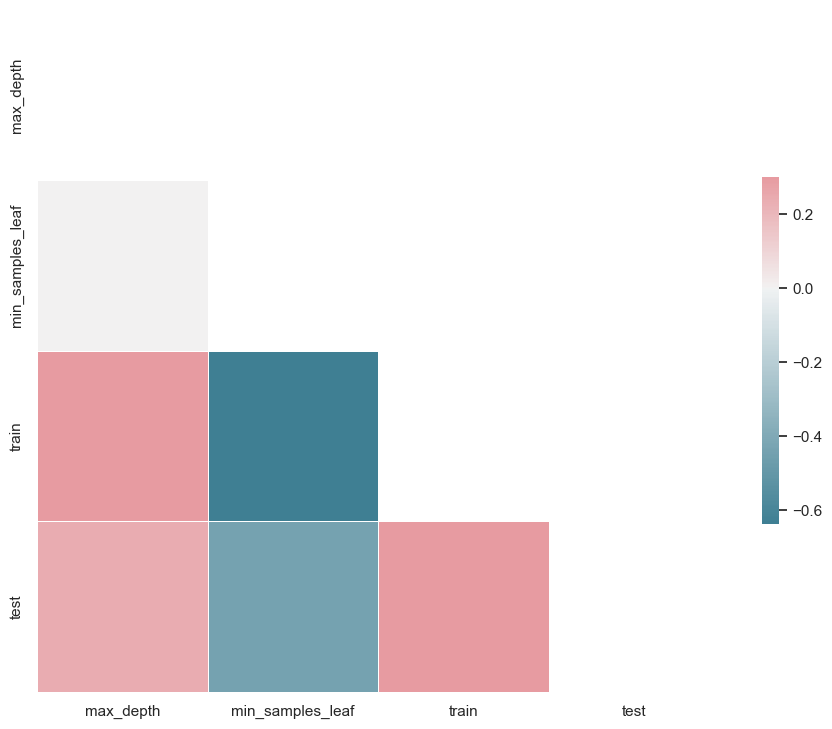

In [148]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

### Explorando Hiperparâmetros em 3 Dimensões e Análise de Correlação

In [154]:
def run_dtc_model(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
    )
    results = cross_validate(
        modelo, x_bad, y_bad, cv=cv, groups=df.modelo, return_train_score=True
    )

    fit_time = results["fit_time"].mean()
    score_time = results["score_time"].mean()
    train_score = results["train_score"].mean() * 100
    test_score = results["test_score"].mean() * 100

    return [
        max_depth,
        min_samples_leaf,
        min_samples_split,
        train_score,
        test_score,
        fit_time,
        score_time,
    ]


results = []
for max_depth in range(1, 33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
            results.append(
                run_dtc_model(max_depth, min_samples_leaf, min_samples_split)
            )

results = pd.DataFrame(
    results,
    columns=[
        "max_depth",
        "min_samples_leaf",
        "min_samples_split",
        "train",
        "test",
        "fit_time",
        "score_time",
    ],
)

results.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.003854,0.001001
1,1,32,64,75.791169,75.784219,0.003903,0.001101
2,1,32,128,75.791169,75.784219,0.003703,0.001001
3,1,32,256,75.791169,75.784219,0.004133,0.001054
4,1,64,32,75.791169,75.784219,0.004104,0.001001


In [155]:
corr = results.corr()

<AxesSubplot:>

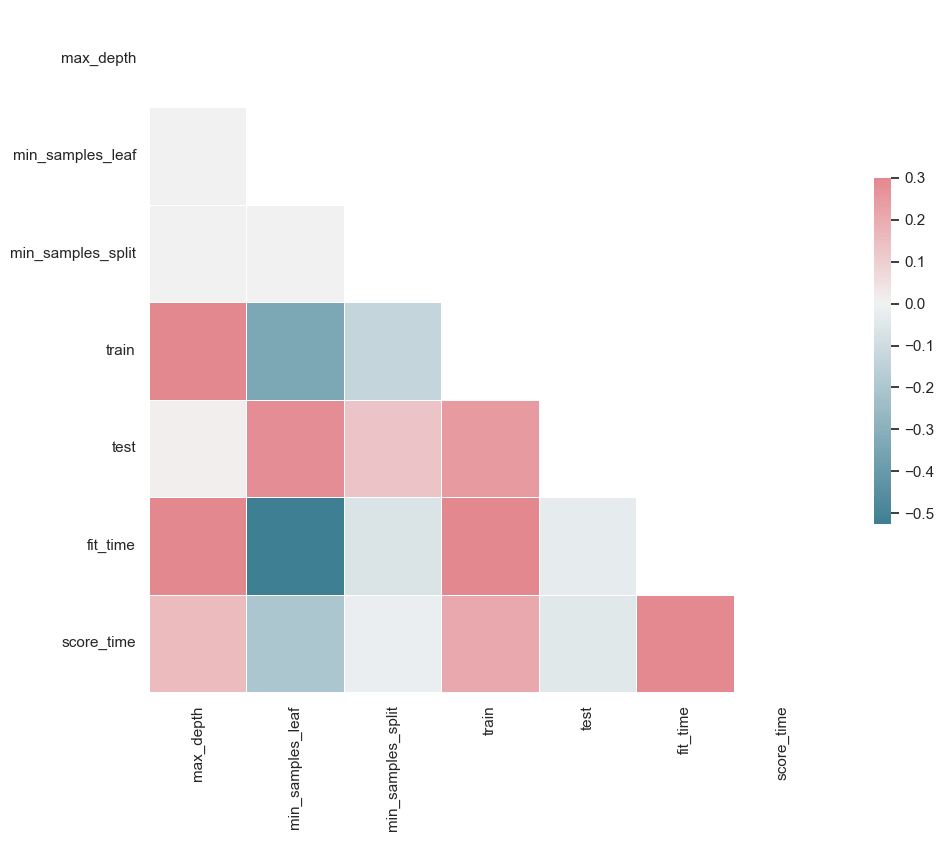

In [156]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

In [157]:
results.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.008522,0.001001
48,4,32,32,78.750993,78.672633,0.009102,0.001203
34,3,32,128,78.750993,78.672633,0.007307,0.001001
35,3,32,256,78.750993,78.672633,0.007171,0.001202
36,3,64,32,78.750993,78.672633,0.008296,0.001401


### Explorando espaço de Hiperparâmetros com GridSearchCV

O GridSearchCV é uma ferramenta usada para automatizar o processo de ajuste dos parâmetros de um algoritmo, pois ele fará de maneira sistemática diversas combinações dos parâmetros e depois de avaliá-los os armazenará num único objeto.

In [162]:
SEED = 301
np.random.seed(SEED)

parameters = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"],
}

search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=GroupKFold(n_splits=10))

search.fit(x_bad, y_bad, groups=df.modelo)

results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008808,1.077691e-03,0.001702,0.000782,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.008008,6.125084e-07,0.001401,0.000490,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.008058,7.230210e-04,0.001252,0.000512,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.007367,4.506812e-04,0.001101,0.000300,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.007307,4.587919e-04,0.001201,0.000400,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [163]:
print(search.best_params_)
print(search.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [164]:
best_estimator = search.best_estimator_
best_estimator

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

### Análise Otimista da Amostragem de Teste

In [166]:
predicts = best_estimator.predict(x_bad)
accuracy = accuracy_score(predicts, y_bad) * 100
print("Acurária: %.2f%%" % accuracy)

Acurária: 78.75%


### Análise sem Vício com Validação Cruzada nos Testes (Nested Cross Validation)

O modelo sem a utilização do nested cross validade usa o mesmo conjunto de dados para treinar e testar repetidas vezes, alterando somente qual parcela é utilizada para treino e qual para teste, mas o algoritmo já "viu" aqueles dados antes a medida que vai sendo realizado o CV, e isso pode "vazar" informações para o modelo e causar overfit. Com o nested cross validade separa-se o conjunto não apenas em treino e teste, mas em treino-validação-teste, seria algo como "um cross validade dentro de um cross validade", ou seja um cross validade aninhado (nested cross validade). Com isso garante-se que uma parcela dos dados serão os dados nunca vistos (conjunto de teste), e as outras parcelas serão utilizadas para treinar e validar diversas vezes (conjuntos treino-validação). O objetivo é evitar o overfit e ter uma métrica mais real de como o modelo estará se trabalhando no mundo real.

In [168]:
try:
    scores = cross_val_score(
        search, x_bad, y_bad, cv=GroupKFold(n_splits=10), groups=df.modelo
    )
except:
    print(
        "A Biblioteca Pandas não suporta Nested Cross Validation com GroupKFold, utiliza-se, portanto, somente o KFold."
    )

A Biblioteca Pandas não suporta Nested Cross Validation com GroupKFold, utiliza-se, portanto, somente o KFold.


In [171]:
SEED = 301
np.random.seed(SEED)

parameters = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"],
}

search = GridSearchCV(
    DecisionTreeClassifier(), parameters, cv=KFold(n_splits=5, shuffle=True)
)

search.fit(x_bad, y_bad)

results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007949,6.433056e-04,0.001201,4.006393e-04,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.007407,4.906223e-04,0.001602,4.900771e-04,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.007206,4.007844e-04,0.001201,4.001619e-04,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.007006,5.761645e-07,0.001001,2.431402e-07,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.006806,4.003764e-04,0.001001,1.907349e-07,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


### Análise com Cross Validation Score e Exibição da melhor Árvore de Decisão

O método cross_val_score realiza todo o trabalho que tivemos para executar um modelo, dividir a base de dados em treino e teste e através do parâmetro cv informamos quantas vezes isso será executado e teremos o mesmo resultado final

In [178]:
scores = cross_val_score(search, x_bad, y_bad, cv=KFold(n_splits=5, shuffle=True))
scores

array([0.7795, 0.7905, 0.786 , 0.791 , 0.788 ])

In [179]:
def print_score(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print("Acurácia Média: %.2f%%" % media)
    print(
        "Intervalo de Acurácia: %.2f%% a %.2f%%"
        % (media - 2 * desvio, media + 2 * desvio)
    )


print_score(scores)

Acurácia Média: 78.70%
Intervalo de Acurácia: 77.87% a 79.53%


In [180]:
best_estimator = search.best_estimator_
best_estimator

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

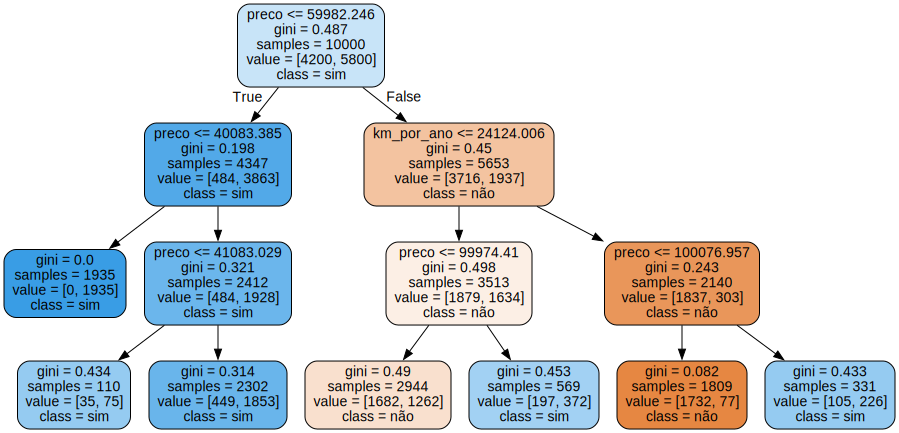

In [181]:
features = x_bad.columns

dot_data = export_graphviz(
    best_estimator,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=["não", "sim"],
    feature_names=features,
)

graph = graphviz.Source(dot_data)
graph

### Exploração de Hiperparâmetros com RandomizedSearchCV

O GridSearchCV faz todas as combinações possíveis dos parâmetros que lhes foram passados na hora de fazer o ajuste fino do modelo, enquanto o RandomizedSearchCV faz apenas uma quantidade específica e limitada de combinações aleatórias, e nós é que determinamos quantas iterações queremos que sejam feitas: se determinamos que o algoritmo faça vinte combinações, por exemplo, ele fará apenas vinte.

RandomizedSearchCV tem vantagem do tempo. Existem muitas discussões e vários estudos para se tentar definir qual é a melhor, e boa parte dos pesquisadores defende que uma função como o RandomizedSearchCV é, muitas vezes, a melhor opção.

In [182]:
from sklearn.model_selection import RandomizedSearchCV

SEED = 301
np.random.seed(SEED)

parameters = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"],
}

seach = RandomizedSearchCV(
    DecisionTreeClassifier(),
    parameters,
    n_iter=16,
    cv=KFold(n_splits=5, shuffle=True),
    random_state=SEED,
)

seach.fit(x_bad, y_bad)

results = pd.DataFrame(seach.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009007,4.101908e-07,0.001402,4.900572e-04,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.007006,1.907349e-07,0.001001,2.431402e-07,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.006706,4.001630e-04,0.001001,2.132481e-07,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.012111,2.016307e-04,0.001201,4.005194e-04,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.012012,3.823628e-06,0.001202,4.003764e-04,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [183]:
scores = cross_val_score(seach, x_bad, y_bad, cv=KFold(n_splits=5, shuffle=True))
print_score(scores)

Acurácia Média: 78.71%
Intervalo de Acurácia: 77.49% a 79.93%


In [184]:
best_estimator = search.best_estimator_
best_estimator

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

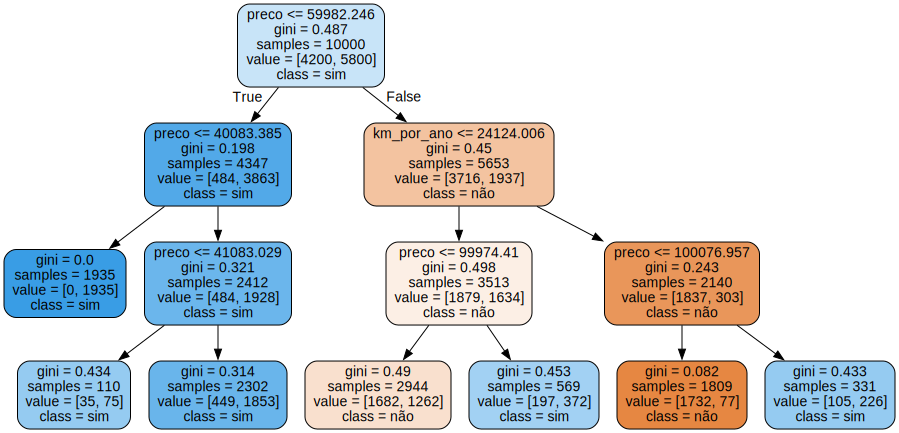

In [185]:
features = x_bad.columns

dot_data = export_graphviz(
    best_estimator,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=["não", "sim"],
    feature_names=features,
)

graph = graphviz.Source(dot_data)
graph

### Alterando o espaço de Hiperparâmetros

In [187]:
from scipy.stats import randint

SEED = 301
np.random.seed(SEED)

parameters = {
    "max_depth": [3, 5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"],
}

search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    parameters,
    n_iter=16,
    cv=KFold(n_splits=5, shuffle=True),
    random_state=SEED,
)

search.fit(x_bad, y_bad)

results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009134,0.000203,0.001324,0.000413,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.012304,0.000621,0.001126,0.000249,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.011313,0.000402,0.001201,0.000400,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.014877,0.000577,0.001275,0.000390,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.013680,0.001555,0.001802,0.000749,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [189]:
scores = cross_val_score(search, x_bad, y_bad, cv=KFold(n_splits=5, shuffle=True))
print_score(scores)

best_estimator = search.best_estimator_
best_estimator

Acurácia Média: 78.70%
Intervalo de Acurácia: 76.85% a 80.55%


DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)

In [192]:
ordered_median_results = results.sort_values("mean_test_score", ascending=False)

for index, row in ordered_median_results.iterrows():
    print(
        "%.3f\t+-(%.3f)\t%s" % (row.mean_test_score, row.std_test_score * 2, row.params)
    )

0.787	+-(0.019)	{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
0.787	+-(0.019)	{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 64}
0.787	+-(0.019)	{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 128, 'min_samples_split': 128}
0.787	+-(0.019)	{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 128, 'min_samples_split': 64}
0.787	+-(0.019)	{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 128, 'min_samples_split': 32}
0.787	+-(0.019)	{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 64, 'min_samples_split': 128}
0.787	+-(0.019)	{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 64, 'min_samples_split': 64}
0.787	+-(0.019)	{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 64, 'min_samples_split': 32}
0.787	+-(0.019)	{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 128}
0.787	+-(0.019)	{'criterion': 'entropy', 'max_

### Exploração Aleatória mais Profunda

In [195]:
SEED = 564
np.random.seed(SEED)

parameters = {
    "max_depth": [3, 5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"],
}

tic = time.time()
search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    parameters,
    n_iter=16,
    cv=KFold(n_splits=5, shuffle=True),
    random_state=SEED,
)
search.fit(x_bad, y_bad)
tac = time.time()
print(f"Tempo de Treinamento: {'{:.2f}'.format(tac - tic)} segundos")

results = pd.DataFrame(search.cv_results_)
results.head()

Tempo de Treinamento: 1.17 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016615,0.000490,0.001402,0.000490,entropy,None,84,103,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7780,0.7745,0.7735,0.7620,0.7625,0.7701,0.006583,16
1,0.006605,0.000491,0.001402,0.000490,gini,3,53,60,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7905,0.7855,0.7915,0.7905,0.7765,0.7869,0.005607,1
2,0.011711,0.000400,0.001023,0.000043,gini,30,118,61,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7775,0.7745,0.7785,0.7720,0.7875,0.7780,0.005273,7
3,0.019417,0.000490,0.001602,0.000490,entropy,None,53,85,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7710,0.7780,0.7760,0.7650,0.7655,0.7711,0.005295,15
4,0.013212,0.000400,0.001202,0.000400,gini,10,44,67,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7755,0.7780,0.7835,0.7695,0.7735,0.7760,0.004669,9


### GridSearchCV vs RandomizedSearch

In [197]:
SEED = 301
np.random.seed(SEED)

parameters = {
    "n_estimators": [10, 100],
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

tic = time.time()
search = RandomizedSearchCV(
    RandomForestClassifier(),
    parameters,
    n_iter=16,
    cv=KFold(n_splits=5, shuffle=True),
    random_state=SEED,
)

search.fit(x_bad, y_bad)
tac = time.time()
print(f"Tempo de Treinamento: {'{:.2f}'.format(tac - tic)} segundos")

results = pd.DataFrame(search.cv_results_)
results.head()

Tempo de Treinamento: 18.00 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.338042,0.007330,0.015516,0.000631,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7270,0.7580,0.7950,0.7850,0.7625,0.7655,0.023656,10
1,0.044240,0.003313,0.003203,0.000401,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.7425,0.7555,0.7915,0.7745,0.7630,0.7654,0.016687,11
2,0.454974,0.004364,0.017818,0.000401,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7760,0.7585,0.7945,0.7855,0.7625,0.7754,0.013559,3
3,0.030427,0.000801,0.002803,0.000400,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7510,0.7580,0.7725,0.7845,0.7445,0.7621,0.014558,15
4,0.036836,0.001721,0.002503,0.000447,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7755,0.7555,0.7500,0.7725,0.7620,0.7631,0.009723,13


In [198]:
ordered_median_results = results.sort_values("mean_test_score", ascending=False)

for index, row in ordered_median_results.iterrows():
    print(
        "%.3f\t+-(%.3f)\t%s" % (row.mean_test_score, row.std_test_score * 2, row.params)
    )

0.777	+-(0.026)	{'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776	+-(0.028)	{'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.775	+-(0.027)	{'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.775	+-(0.028)	{'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.775	+-(0.028)	{'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.774	+-(0.029)	{'n_estimators': 100, 'min_samples_split': 128, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
0.772	+-(0.029)	{'n_estimators': 100, 'min_samples_split': 128, 'min_samples_leaf': 32, 'max_depth': 3, 'criterion': 'entropy

In [199]:
tic = time.time()
scores = cross_val_score(search, x_bad, y_bad, cv=KFold(n_splits=5, shuffle=True))
tac = time.time()

print(f"Tempo de Validação dos Scores: {'{:.2f}'.format(tac - tic)} segundos")

print_score(scores)
best_estimator = search.best_estimator_
best_estimator

Tempo de Validação dos Scores: 73.56 segundos
Acurácia Média: 77.48%
Intervalo de Acurácia: 76.33% a 78.63%


RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=32,
                       min_samples_split=64)

### Caso: Não é possível utilizar o Cross Validation

Se faz necessária a criação de uma amostragem de validação.

- Treino: esse dataset é usado para o treino, ou seja, o fit do modelo. Por exemplo, numa regressão os parâmetros são ajustados para minimizar o erro nesse dataset.
- Validação: esse dataset é usado para a avaliação não-viesada da performance do modelo durante o ajuste de hiperparâmetros.
- Teste: esse dataset é usado para a avaliação final do modelo. Não deve ser usado durante o treino e a validação.

Uso de StratifiedShuffleSplit, uma combinação entre ShuffleSplit e StratifiedKFold. Quando usamos o StratifiedShuffleSplit, a proporção de distribuição de rótulos das classes é quase uniforme entre o conjunto de treino e teste, e a principal diferença entre o StratifiedShuffleSplit e StratifiedKFold (shuffle = True) é que no StratifiedKFold o conjunto de dados é embaralhado apenas uma vez no início, e depois é dividido no número especificado de n_splits, isso descarta a chance de sobreposição dos conjuntos de treino e teste, porém no StratifiedShuffleSplit os dados são embaralhados a cada vez que a divisão é feita, por isso é possível que os dados de treino e teste sejam sobrepostos.



In [207]:
SEED = 301
np.random.seed(SEED)

x_test_train, x_validation, y_test_train, y_validation = train_test_split(
    x_bad, y_bad, test_size=0.2, shuffle=True, stratify=y_bad
)

print(x_test_train.shape)
print(x_validation.shape)
print(y_test_train.shape)
print(y_validation.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [208]:
parameters = {
    "n_estimators": randint(10, 101),
    "max_depth": randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25)

tic = time.time()
search = RandomizedSearchCV(RandomForestClassifier(), parameters, n_iter=5, cv=split)
search.fit(x_test_train, y_test_train)
tac = time.time()
print(f"Tempo de Treinamento: {'{:.2f}'.format(tac - tic)} segundos")

results = pd.DataFrame(search.cv_results_)
results.head()

Tempo de Treinamento: 0.87 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.099091,0.0,0.007006,0.0,True,gini,5,89,58,24,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7885,0.7885,0.0,3
1,0.105095,0.0,0.006006,0.0,False,entropy,3,71,55,27,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7920,0.7920,0.0,1
2,0.078071,0.0,0.007007,0.0,True,entropy,3,33,99,21,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7910,0.7910,0.0,2
3,0.198186,0.0,0.011010,0.0,True,gini,3,98,100,67,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7785,0.7785,0.0,5
4,0.229208,0.0,0.011010,0.0,False,entropy,4,88,64,63,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7885,0.7885,0.0,3


In [209]:
scores = cross_val_score(search, x_validation, y_validation, cv=split)
scores

array([0.732])